In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import preprocessing
import xgboost as xgb


import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv', 'data_description.txt']


In [2]:
# setting the number of cross validations used in the Model part 
nr_cv = 5

# switch for using log values for SalePrice and features     
use_logvals = 1    
# target used for correlation 
target = 'SalesPrice_log'
    
# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.4    
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

In [3]:
test_df = pd.read_csv("../input/test.csv")
train_df = pd.read_csv("../input/train.csv")
y_train = train_df["SalePrice"]

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

In [5]:

X_train = train_df.drop("SalePrice", axis = 1)
X_test = test_df.copy()
len_train = len(X_train)
dataset = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)


In [6]:
dataset.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [7]:
dataset.fillna(np.nan)
dataset.info()
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1420
GarageType        157
GarageYrBlt       159
GarageFinish      159
GarageCars          1
GarageArea          1
GarageQual        159
GarageCond

In [8]:
dataset.dtypes


Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


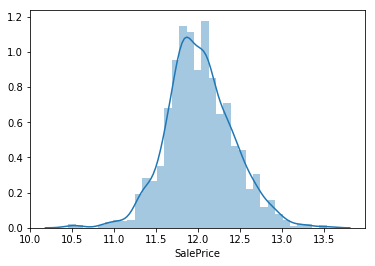

In [9]:
sns.distplot(np.log(y_train))

In [10]:
train_df["SalesPrice_log"] = np.log(train_df["SalePrice"])
train_df.drop("SalePrice", axis=1, inplace=True)

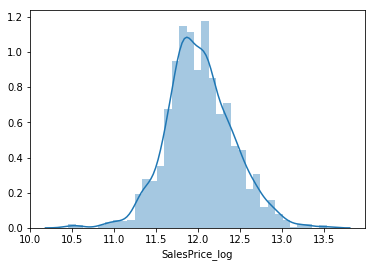

In [11]:
sns.distplot(train_df["SalesPrice_log"])

In [12]:
num_feats = train_df.dtypes[train_df.dtypes != "object"].index
print("Number of Numerical features: ", len(num_feats))

categ_feats = train_df.dtypes[train_df.dtypes == "object"].index
print("Number of Categorical features: ", len(categ_feats))

Number of Numerical features:  38
Number of Categorical features:  43


In [13]:
print(train_df[num_feats].columns)
print("*"*100)
print(train_df[categ_feats].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalesPrice_log'],
      dtype='object')
****************************************************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Found

In [14]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [15]:
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']
for col in cols_fillna:
    train_df[col].fillna("None", inplace = True)
    test_df[col].fillna("None", inplace = True)

In [16]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
SalesPrice_log,0,0.000000
ExterCond,0,0.000000


In [17]:
train_df["LotFrontage"].fillna(train_df["LotFrontage"].mean(), inplace = True)
train_df["GarageYrBlt"].fillna(train_df["GarageYrBlt"].mean(), inplace = True)
train_df["MasVnrArea"].fillna(train_df["MasVnrArea"].mean(), inplace = True)
test_df["LotFrontage"].fillna(test_df["LotFrontage"].mean(), inplace = True)
test_df["GarageYrBlt"].fillna(test_df["GarageYrBlt"].mean(), inplace = True)
test_df["MasVnrArea"].fillna(test_df["MasVnrArea"].mean(), inplace = True)

In [18]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
SalesPrice_log,0,0.0
Heating,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0


In [19]:
for col in num_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(train_df[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(train_df[col].kurt())  
         )

Id              Skewness: 00.00     Kurtosis: -01.20
MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotFrontage     Skewness: 02.38     Kurtosis: 021.85
LotArea         Skewness: 12.21     Kurtosis: 203.24
OverallQual     Skewness: 00.22     Kurtosis: 000.10
OverallCond     Skewness: 00.69     Kurtosis: 001.11
YearBuilt       Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50     Kurtosis: -01.27
MasVnrArea      Skewness: 02.68     Kurtosis: 010.15
BsmtFinSF1      Skewness: 01.69     Kurtosis: 011.12
BsmtFinSF2      Skewness: 04.26     Kurtosis: 020.11
BsmtUnfSF       Skewness: 00.92     Kurtosis: 000.47
TotalBsmtSF     Skewness: 01.52     Kurtosis: 013.25
1stFlrSF        Skewness: 01.38     Kurtosis: 005.75
2ndFlrSF        Skewness: 00.81     Kurtosis: -00.55
LowQualFinSF    Skewness: 09.01     Kurtosis: 083.23
GrLivArea       Skewness: 01.37     Kurtosis: 004.90
BsmtFullBath    Skewness: 00.60     Kurtosis: -00.84
BsmtHalfBath    Skewness: 04.10     Kurtosis: 

In [20]:
for df in [train_df, test_df]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
    
    
num_feats = train_df.dtypes[train_df.dtypes != "object"].index

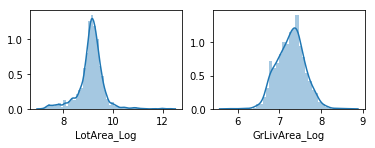

In [21]:
plt.subplot(221)
sns.distplot(train_df['LotArea_Log']);
plt.subplot(222)
sns.distplot(train_df['GrLivArea_Log']);

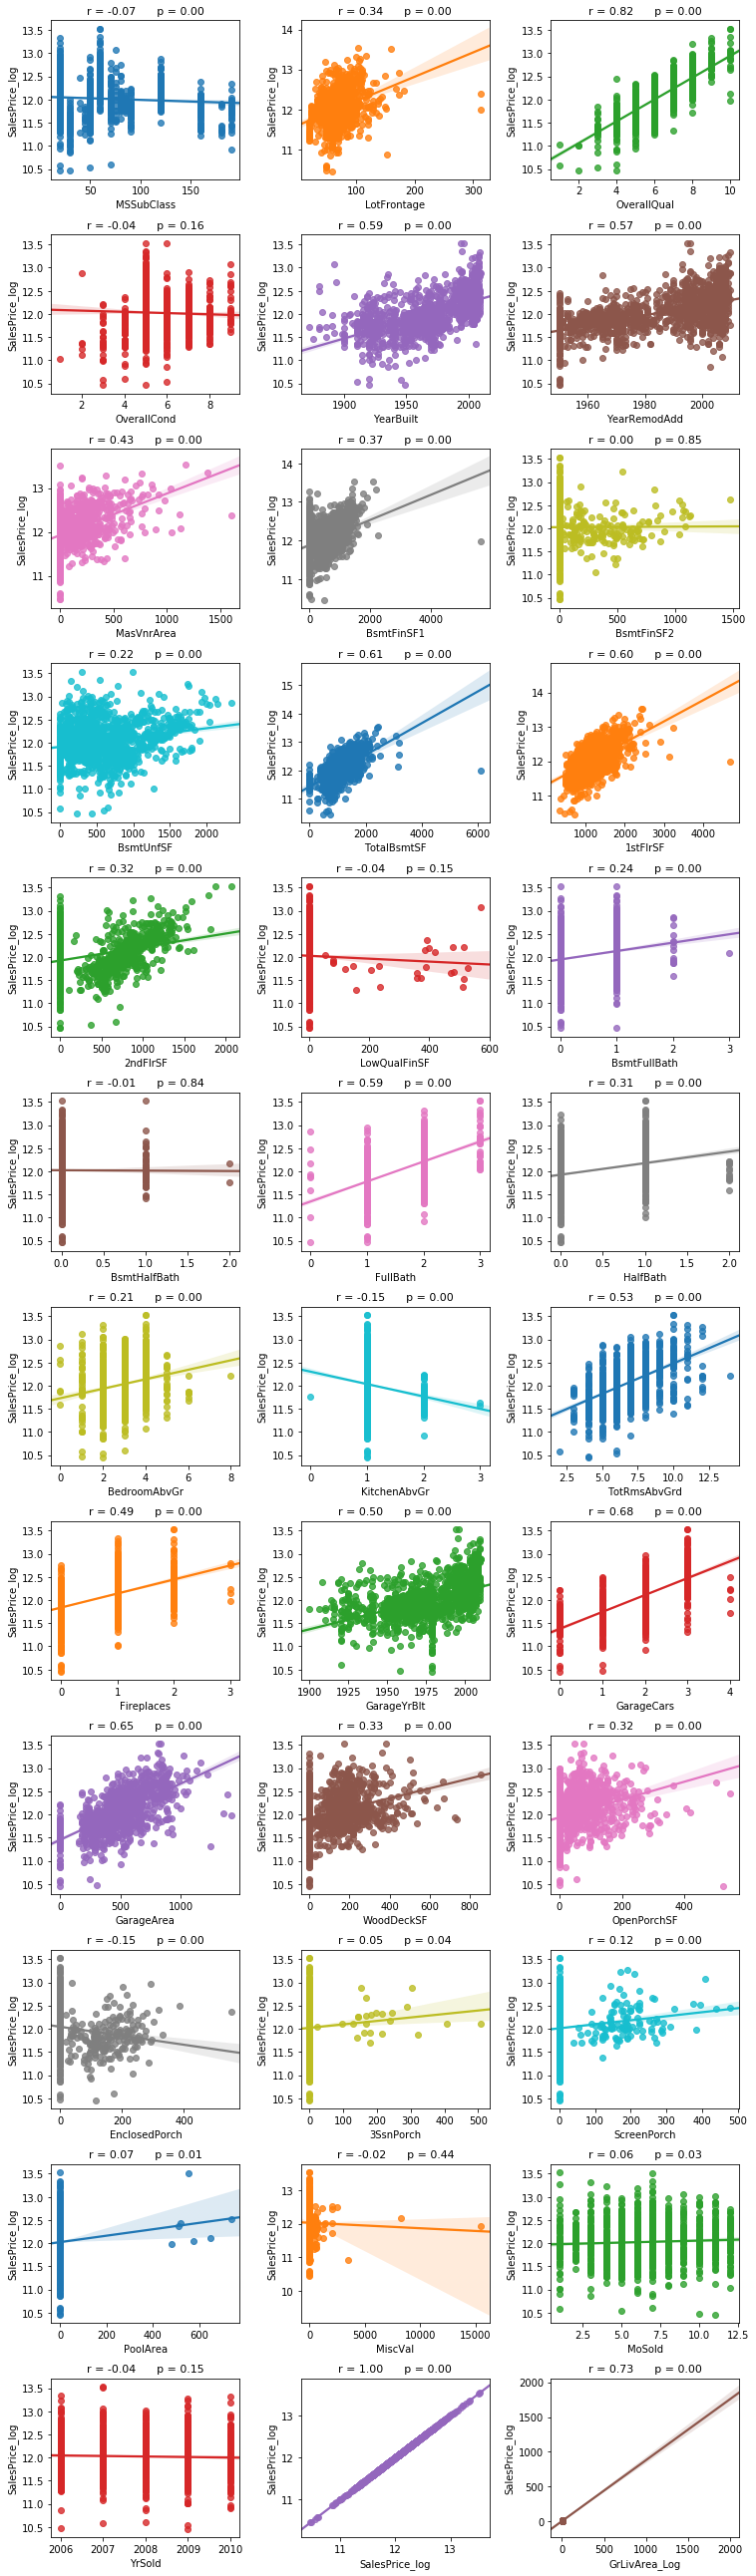

In [22]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(num_feats)
li_not_plot = ['Id', 'SalePrice', 'SalesPrice_Log']
li_plot_num_feats = [c for c in list(num_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(train_df[li_plot_num_feats[i]], train_df[target], ax = axs[r][c])
            stp = stats.pearsonr(train_df[li_plot_num_feats[i]], train_df[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show() 

In [23]:
corr = train_df.corr()
corr_abs = corr.abs()
nr_num_cols = len(num_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]
cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [24]:
print(ser_corr)
print("*"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

SalesPrice_log    1.000000
OverallQual       0.817184
GrLivArea_Log     0.730255
GarageCars        0.680625
GarageArea        0.650888
TotalBsmtSF       0.612134
1stFlrSF          0.596981
FullBath          0.594771
YearBuilt         0.586570
YearRemodAdd      0.565608
TotRmsAbvGrd      0.534422
GarageYrBlt       0.500449
Fireplaces        0.489449
MasVnrArea        0.429531
LotArea_Log       0.399918
BsmtFinSF1        0.372023
LotFrontage       0.336156
WoodDeckSF        0.334135
OpenPorchSF       0.321053
2ndFlrSF          0.319300
HalfBath          0.313982
BsmtFullBath      0.236224
BsmtUnfSF         0.221985
BedroomAbvGr      0.209044
EnclosedPorch     0.149050
KitchenAbvGr      0.147548
ScreenPorch       0.121208
MSSubClass        0.073959
PoolArea          0.069798
MoSold            0.057329
3SsnPorch         0.054900
LowQualFinSF      0.037963
YrSold            0.037263
OverallCond       0.036868
MiscVal           0.020021
Id                0.017942
BsmtHalfBath      0.005149
B

In [25]:
for catg in list(categ_feats) :
    print(train_df[catg].value_counts())
    print('#'*50)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1454
Grvl       6
Name: Street, dtype: int64
##################################################
None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
###########################

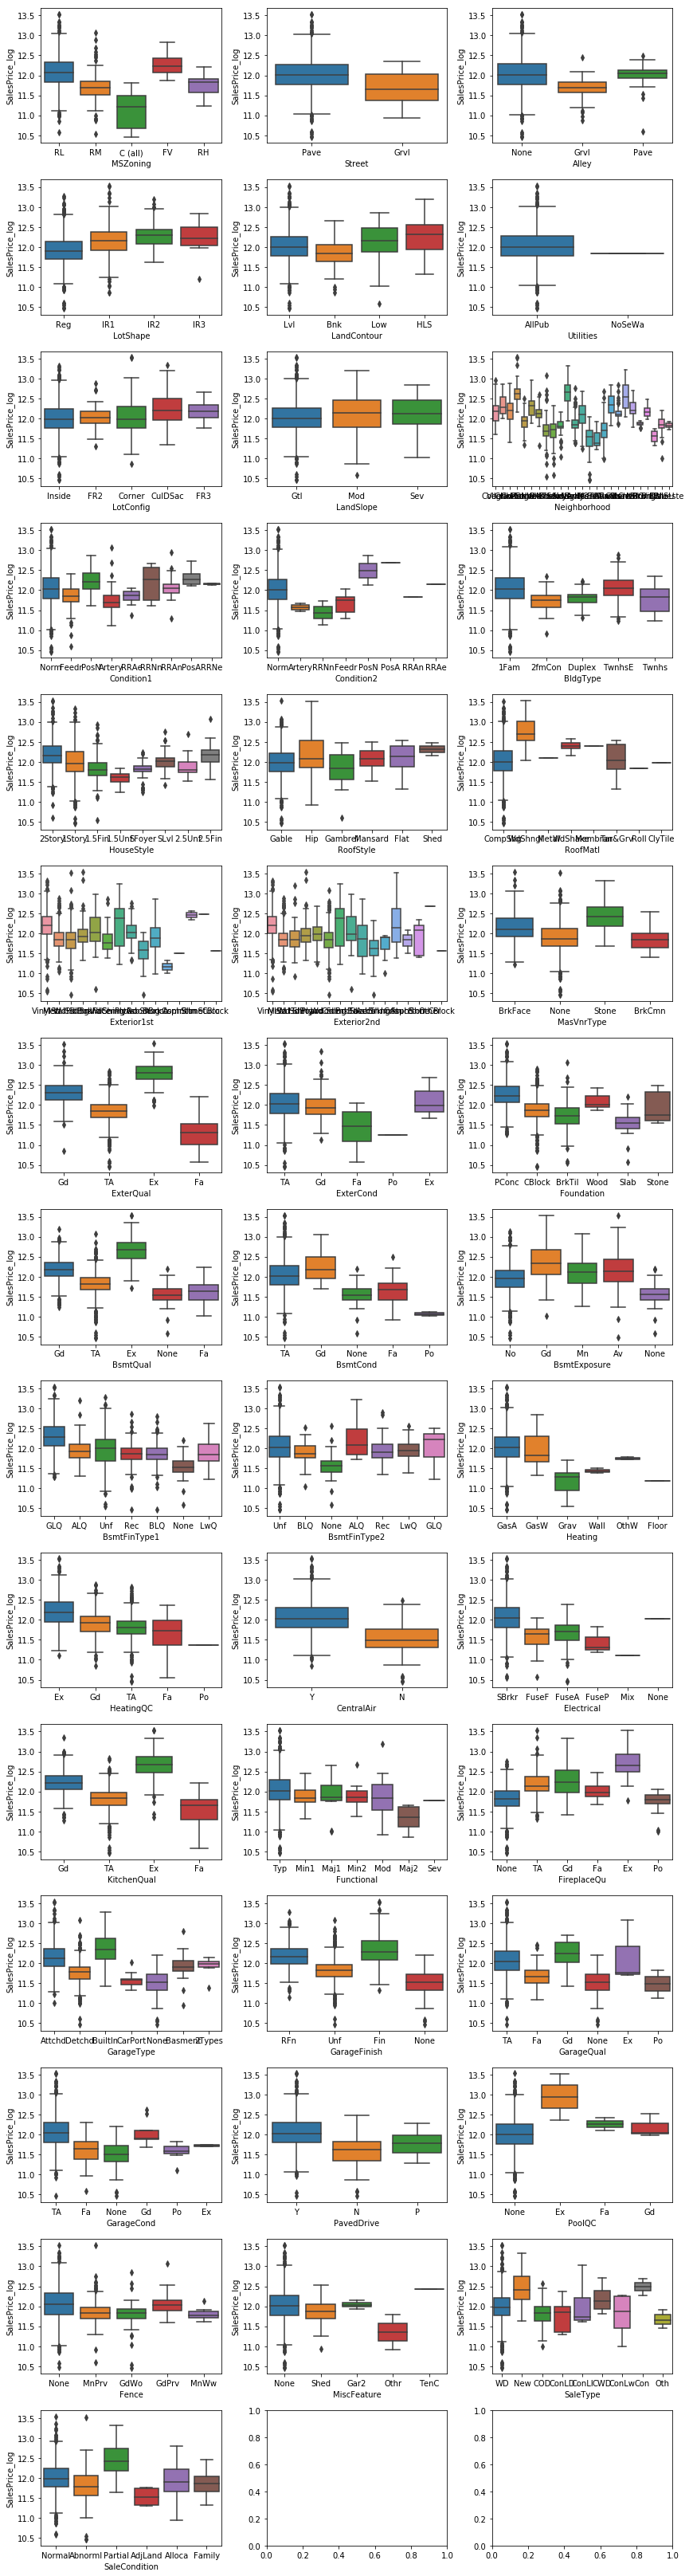

In [26]:
li_cat_feats = list(categ_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=train_df, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()   

In [27]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

In [28]:
nr_feats = len(cols_abv_corr_limit)

In [29]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score    

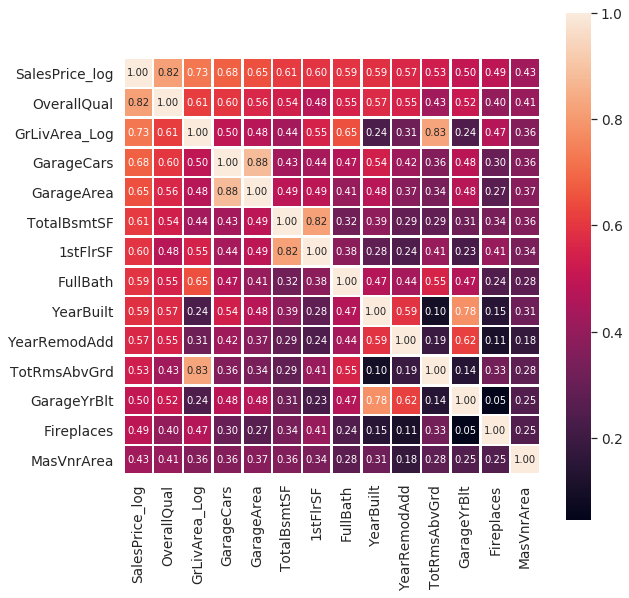

In [30]:
plot_corr_matrix(train_df, nr_feats, target)

In [31]:
id_test = test_df["Id"]

to_drop_num = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ["Id"] + to_drop_catg + to_drop_num

for df in [train_df, test_df]:
    df.drop(cols_to_drop, inplace = True, axis =1)
    

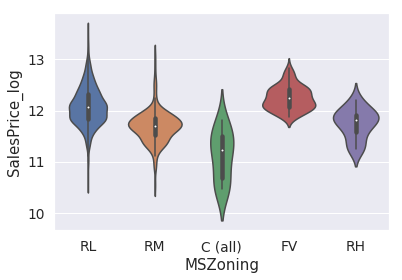

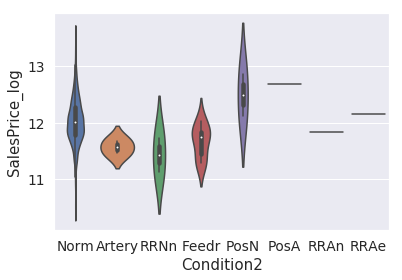

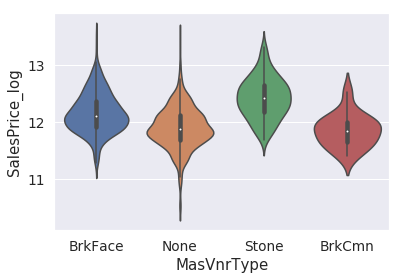

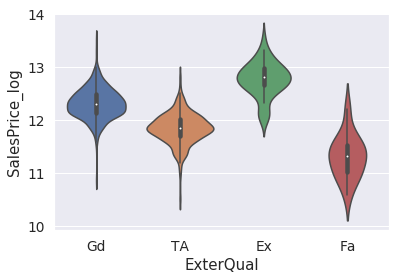

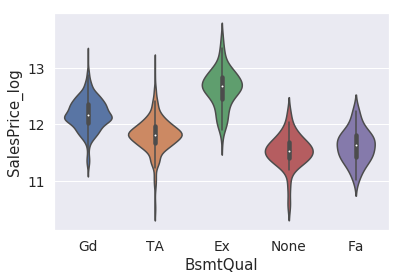

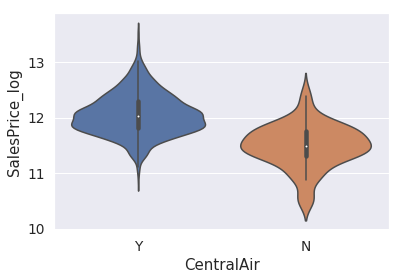

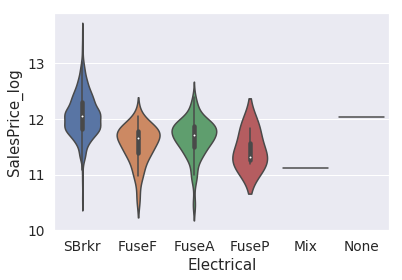

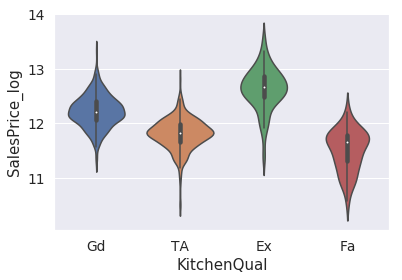

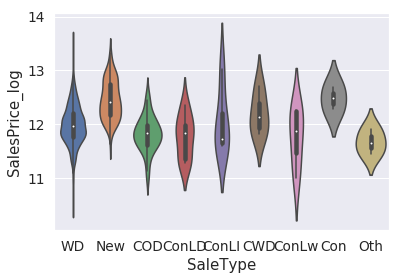

In [32]:
catg_list = catg_strong_corr.copy()
catg_list.remove("Neighborhood")

for catg in catg_list:
    sns.violinplot(x=catg, y = target, data = train_df)
    plt.show()

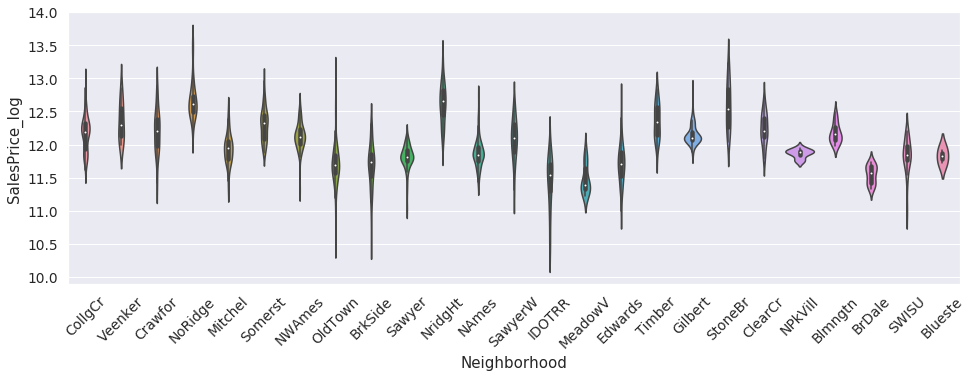

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='Neighborhood', y=target, data=train_df, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [34]:
for catg in catg_list :
    g = train_df.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)    11.118259
FV         12.246616
RH         11.749840
RL         12.085885
RM         11.692893
Name: SalesPrice_log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.670631
Norm      12.025895
PosA      12.691580
PosN      12.493879
RRAe      12.154779
RRAn      11.827043
RRNn      11.435329
Name: SalesPrice_log, dtype: float64
MasVnrType
BrkCmn     11.853239
BrkFace    12.163630
None       11.896884
Stone      12.425138
Name: SalesPrice_log, dtype: float64
ExterQual
Ex    12.764044
Fa    11.304541
Gd    12.311282
TA    11.837985
Name: SalesPrice_log, dtype: float64
BsmtQual
Ex      12.640394
Fa      11.617600
Gd      12.179882
None    11.529680
TA      11.810855
Name: SalesPrice_log, dtype: float64
CentralAir
N    11.491858
Y    12.061090
Name: SalesPrice_log, dtype: float64
Electrical
FuseA    11.660315
FuseF    11.539624
FuseP    11.446808
Mix      11.112448
None     12.028739
SBrkr    12.061464
Name: SalesPrice_log, dtype: float64
KitchenQual
Ex    12.6

In [35]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

In [37]:
for df in [train_df, test_df]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4

In [38]:
catg_cols_to_drop = ['Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

corr1 = train_df.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(train_df)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)


for df in [train_df, test_df] :
    df.drop(catg_cols_to_drop, inplace= True, axis = 1)
    df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1)  

SalesPrice_log    1.000000
OverallQual       0.817184
GrLivArea_Log     0.730255
NbHd_num          0.696515
GarageCars        0.680625
ExtQ_num          0.678840
KiQ_num           0.667893
BsQ_num           0.659285
GarageArea        0.650888
TotalBsmtSF       0.612134
1stFlrSF          0.596981
FullBath          0.594771
YearBuilt         0.586570
YearRemodAdd      0.565608
TotRmsAbvGrd      0.534422
GarageYrBlt       0.500449
Fireplaces        0.489449
MasVnrArea        0.429531
MSZ_num           0.409405
CA_num            0.351600
SlTy_num          0.335339
Mas_num           0.311369
Elc_num           0.304862
Cond2_num         0.105442
Name: SalesPrice_log, dtype: float64


In [39]:
corr2 = train_df.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(train_df)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, target)[target]

print(ser_corr_2)

SalesPrice_log    1.000000
OverallQual       0.817184
GrLivArea_Log     0.730255
NbHd_num          0.696515
GarageCars        0.680625
ExtQ_num          0.678840
KiQ_num           0.667893
BsQ_num           0.659285
GarageArea        0.650888
TotalBsmtSF       0.612134
1stFlrSF          0.596981
FullBath          0.594771
YearBuilt         0.586570
YearRemodAdd      0.565608
TotRmsAbvGrd      0.534422
GarageYrBlt       0.500449
Fireplaces        0.489449
MasVnrArea        0.429531
MSZ_num           0.409405
Name: SalesPrice_log, dtype: float64


In [40]:
corr = train_df.corr()
corr_abs = corr.abs()

nr_all_cols = len(train_df)
print (corr_abs.nlargest(nr_all_cols, target)[target])

SalesPrice_log    1.000000
OverallQual       0.817184
GrLivArea_Log     0.730255
NbHd_num          0.696515
GarageCars        0.680625
ExtQ_num          0.678840
KiQ_num           0.667893
BsQ_num           0.659285
GarageArea        0.650888
TotalBsmtSF       0.612134
1stFlrSF          0.596981
FullBath          0.594771
YearBuilt         0.586570
YearRemodAdd      0.565608
TotRmsAbvGrd      0.534422
GarageYrBlt       0.500449
Fireplaces        0.489449
MasVnrArea        0.429531
MSZ_num           0.409405
Name: SalesPrice_log, dtype: float64


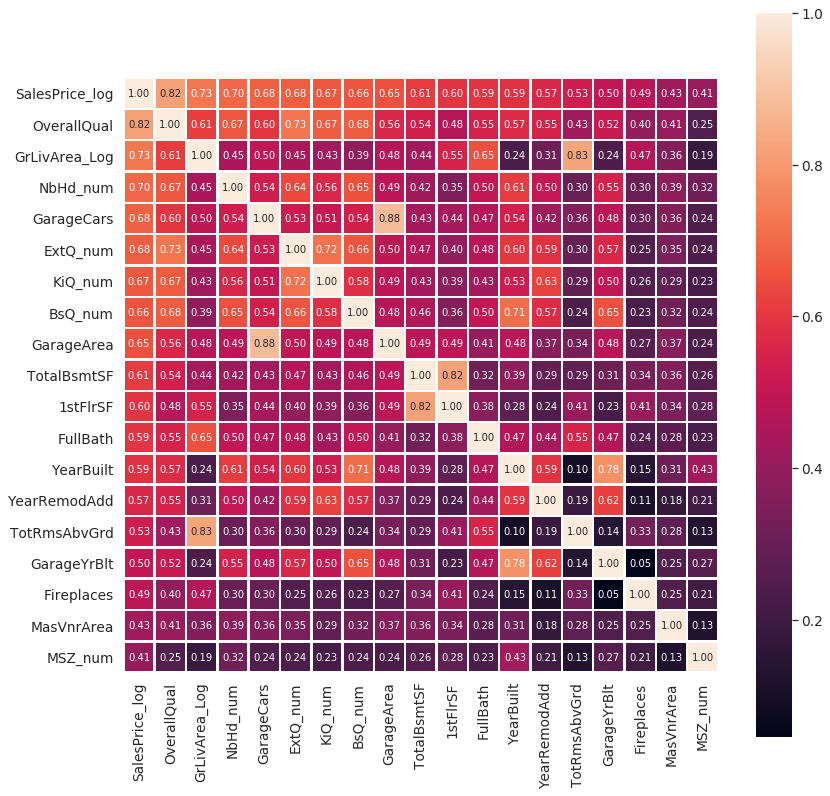

In [41]:
nr_feats=len(train_df.columns)
plot_corr_matrix(train_df, nr_feats, target)

In [42]:
cols = corr_abs.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

if drop_similar == 1 :
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols: 
            cols.remove(col)

In [43]:
cols = list(cols)
print(cols)

['SalesPrice_log', 'OverallQual', 'GrLivArea_Log', 'NbHd_num', 'GarageCars', 'ExtQ_num', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num']


In [46]:
feats = cols.copy()
feats.remove('SalesPrice_log')

print(feats)

['OverallQual', 'GrLivArea_Log', 'NbHd_num', 'GarageCars', 'ExtQ_num', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num']


In [47]:
df_train_ml = train_df[feats].copy()
df_test_ml  = test_df[feats].copy()

y = train_df[target]

In [48]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [49]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.651479,0.529260,0.660250,0.311725,1.052302,0.735994,0.643519,-0.459303,0.789741,1.050994,0.878668,-0.951226,0.511418,0.438502
1,-0.071836,-0.381846,0.660250,0.311725,-0.689604,-0.771091,0.643519,0.466465,0.789741,0.156734,-0.429577,0.600495,-0.574410,0.438502
2,0.651479,0.659675,0.660250,0.311725,1.052302,0.735994,0.643519,-0.313369,0.789741,0.984752,0.830215,0.600495,0.323060,0.438502
3,0.651479,0.541511,0.660250,1.650307,-0.689604,0.735994,-0.922377,-0.687324,-1.026041,-1.863632,-0.720298,0.600495,-0.574410,0.438502
4,1.374795,1.282191,2.164095,1.650307,1.052302,0.735994,0.643519,0.199680,0.789741,0.951632,0.733308,0.600495,1.364570,0.438502


In [52]:
X = df_train_ml.copy()
y = train_df[target]
X_test = df_test_ml.copy()

X_sc = df_train_ml_sc.copy()
y_sc = train_df[target]
X_test_sc = df_test_ml_sc.copy()

X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
OverallQual      1460 non-null int64
GrLivArea_Log    1460 non-null float64
NbHd_num         1460 non-null int64
GarageCars       1460 non-null int64
ExtQ_num         1460 non-null int64
KiQ_num          1460 non-null int64
BsQ_num          1460 non-null int64
TotalBsmtSF      1460 non-null int64
FullBath         1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
Fireplaces       1460 non-null int64
MasVnrArea       1460 non-null float64
MSZ_num          1460 non-null int64
dtypes: float64(2), int64(12)
memory usage: 159.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 14 columns):
OverallQual      1459 non-null int64
GrLivArea_Log    1459 non-null float64
NbHd_num         1459 non-null int64
GarageCars       1458 non-null float64
ExtQ_num         1459 non-null int64
KiQ_num          1459 

In [53]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

In [54]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear.fit(X, y)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.15205060198060458
{'copy_X': True, 'fit_intercept': True, 'normalize': False}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


In [55]:
linreg_sc = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear_sc = GridSearchCV(linreg_sc, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear_sc.fit(X_sc, y)

sc_linear_sc = get_best_score(grid_linear_sc)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.15205060198061068
{'copy_X': True, 'fit_intercept': True, 'normalize': False}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [58]:
all_data = pd.concat((train_df[feats], test_df[feats]))

li_get_dummies = ['OverallQual', 'NbHd_num', 'GarageCars','ExtQ_num', 'KiQ_num',
                  'BsQ_num', 'FullBath', 'Fireplaces', 'MSZ_num']
all_data = pd.get_dummies(all_data, columns=li_get_dummies, drop_first=True)

df_train_ml = all_data[:train_df.shape[0]]
df_test_ml  = all_data[train_df.shape[0]:]

In [64]:
X_test.info()
X_test.fillna(X_test["GarageCars"].mean(), inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 14 columns):
OverallQual      1459 non-null int64
GrLivArea_Log    1459 non-null float64
NbHd_num         1459 non-null int64
GarageCars       1458 non-null float64
ExtQ_num         1459 non-null int64
KiQ_num          1459 non-null int64
BsQ_num          1459 non-null int64
TotalBsmtSF      1458 non-null float64
FullBath         1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
Fireplaces       1459 non-null int64
MasVnrArea       1459 non-null float64
MSZ_num          1459 non-null int64
dtypes: float64(4), int64(10)
memory usage: 159.7 KB


In [65]:
linregr_all = LinearRegression()
#linregr_all.fit(X_train_all, y_train_all)
linregr_all.fit(X, y)
pred_linreg_all = linregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [66]:
sub_linreg = pd.DataFrame()
sub_linreg['Id'] = id_test
sub_linreg['SalePrice'] = pred_linreg_all

In [67]:
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge.fit(X, y)

sc_ridge = get_best_score(grid_ridge)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.15198920691456985
{'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=1e-06)


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.8s finished


In [68]:
ridge_sc = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge_sc = GridSearchCV(ridge_sc, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge_sc.fit(X_sc, y)

sc_ridge_sc = get_best_score(grid_ridge_sc)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.15198920691456977
{'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=1e-06)


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.9s finished


In [69]:
pred_ridge_all = grid_ridge.predict(X_test)

In [70]:
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_lasso.fit(X, y)

sc_lasso = get_best_score(grid_lasso)

pred_lasso = grid_lasso.predict(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.15219910709836398
{'alpha': 0.001, 'normalize': False, 'tol': 0.001}
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.001, warm_start=False)


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    1.2s finished


In [72]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_enet.fit(X_sc, y_sc)

sc_enet = get_best_score(grid_enet)

pred_enet = grid_enet.predict(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.15255989746781143
{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.04, 'max_iter': 1000000, 'normalize': False, 'tol': 0.01}
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.04,
           max_iter=1000000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.01, warm_start=False)


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    1.1s finished


In [73]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_sgd.fit(X_sc, y_sc)

sc_sgd = get_best_score(grid_sgd)

pred_sgd = grid_sgd.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.15393028296957134
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.01,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=10000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [74]:
from sklearn.tree import DecisionTreeRegressor

param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'presort': [False,True] , 'random_state': [5] }
            
grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_dtree.fit(X, y)

sc_dtree = get_best_score(grid_dtree)

pred_dtree = grid_dtree.predict(X_test)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.18344298158072825
{'max_depth': 9, 'max_features': 12, 'max_leaf_nodes': None, 'min_samples_split': 25, 'presort': True, 'random_state': 5}
DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=12,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=25, min_weight_fraction_leaf=0.0,
                      presort=True, random_state=5, splitter='best')


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   11.6s finished


In [75]:
dtree_pred = grid_dtree.predict(X_test)
sub_dtree = pd.DataFrame()
sub_dtree['Id'] = id_test
sub_dtree['SalePrice'] = dtree_pred

In [76]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)

sc_rf = get_best_score(grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   11.8s finished


0.15256434828266197
{'min_samples_split': 4, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=5, verbose=0,
                      warm_start=False)


In [77]:
pred_rf = grid_rf.predict(X_test)

sub_rf = pd.DataFrame()
sub_rf['Id'] = id_test
sub_rf['SalePrice'] = pred_rf 

if use_logvals == 1:
    sub_rf['SalePrice'] = np.exp(sub_rf['SalePrice']) 

sub_rf.to_csv('rf.csv',index=False)

In [78]:
sub_rf.head(10)

,Id,SalePrice
0,1461,115387.493897
1,1462,124890.443749
2,1463,176727.030083
3,1464,188717.414124
4,1465,197318.804017
5,1466,183358.687637
6,1467,165338.596436
7,1468,179491.702537
8,1469,182287.967417
9,1470,118285.779830


In [79]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_knn.fit(X_sc, y_sc)

sc_knn = get_best_score(grid_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.1642359035171552
{'algorithm': 'brute', 'n_neighbors': 6, 'weights': 'uniform'}
KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform')


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.0s finished


In [81]:
pred_knn = grid_knn.predict(X_test)

sub_knn = pd.DataFrame()
sub_knn['Id'] = id_test
sub_knn['SalePrice'] = pred_knn

if use_logvals == 1:
    sub_knn['SalePrice'] = np.exp(sub_knn['SalePrice']) 

sub_knn.to_csv('knn.csv',index=False)

In [82]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel

gpr = GaussianProcessRegressor(random_state=5, alpha=5e-9, 
                                n_restarts_optimizer=0, 
                               optimizer='fmin_l_bfgs_b', 
                               copy_X_train=True)

param_grid = {'normalize_y' : [True,False],
              'kernel' : [DotProduct(), ConstantKernel(1.0, (1e-3, 1e3))] }

grid_gpr = GridSearchCV(gpr, param_grid, cv=nr_cv, verbose=1, scoring = score_calc)
grid_gpr.fit(X_sc, y_sc)

sc_gpr = get_best_score(grid_gpr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5791744.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3266560.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   39.4s finished


0.15205037739563645
{'kernel': DotProduct(sigma_0=1), 'normalize_y': False}
GaussianProcessRegressor(alpha=5e-09, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=5)


In [83]:
pred_gpr = grid_gpr.predict(X_test)

sub_gpr = pd.DataFrame()
sub_gpr['Id'] = id_test
sub_gpr['SalePrice'] = pred_gpr

if use_logvals == 1:
    sub_gpr['SalePrice'] = np.exp(sub_gpr['SalePrice']) 

sub_gpr.to_csv('gpr.csv',index=False)

In [84]:
list_scores = [sc_linear, sc_ridge, sc_lasso, sc_enet,
               sc_sgd, sc_dtree, sc_rf, sc_knn, sc_gpr]
list_regressors = ['Linear','Ridge','Lasso','ElaNet','SGD','DTr','RF','KNN','GPR']

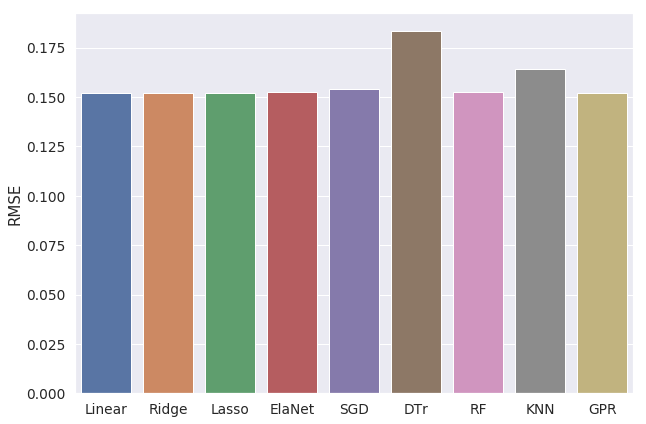

In [85]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

In [86]:
predictions = {'Linear': pred_linreg_all, 'Ridge': pred_ridge_all, 'Lasso': pred_lasso,
               'ElaNet': pred_enet, 'SGD': pred_sgd, 'DTr': pred_dtree, 'RF': pred_rf,
               'KNN': pred_knn, 'GPR': pred_gpr}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,Linear,Ridge,Lasso,ElaNet,SGD,DTr,RF,KNN,GPR
Linear,1.000000,0.999987,0.999802,0.708008,0.709152,0.937055,0.973365,-0.329051,0.707050
Ridge,0.999987,1.000000,0.999853,0.708571,0.709712,0.937048,0.973358,-0.329216,0.707601
Lasso,0.999802,0.999853,1.000000,0.712339,0.713489,0.937677,0.973793,-0.332280,0.711387
ElaNet,0.708008,0.708571,0.712339,1.000000,0.999978,0.690192,0.720367,-0.591987,0.999874
SGD,0.709152,0.709712,0.713489,0.999978,1.000000,0.691099,0.721444,-0.593085,0.999945
DTr,0.937055,0.937048,0.937677,0.690192,0.691099,1.000000,0.968298,-0.308597,0.689046
RF,0.973365,0.973358,0.973793,0.720367,0.721444,0.968298,1.000000,-0.336475,0.719554
KNN,-0.329051,-0.329216,-0.332280,-0.591987,-0.593085,-0.308597,-0.336475,1.000000,-0.595901
GPR,0.707050,0.707601,0.711387,0.999874,0.999945,0.689046,0.719554,-0.595901,1.000000


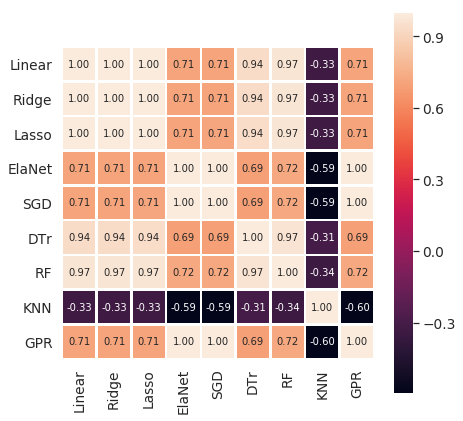

In [87]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.show()

In [88]:
sub_mean = pd.DataFrame()
sub_mean['Id'] = id_test
sub_mean['SalePrice'] = np.round( (pred_lasso + pred_enet + pred_rf + pred_sgd) / 4.0 ) 
sub_mean['SalePrice'] = sub_mean['SalePrice'].astype(float)
sub_mean.to_csv('mean.csv',index=False)